In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from functions import *

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

from scipy.optimize import minimize
from multiprocess import Pool



/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Let $X \sim U[-2,2]$ and 

\begin{equation}
Y_i=a\left\{X_i+2 \exp \left(-16 X_i^2\right)\right\}+\sigma\left(X_i\right) \varepsilon_i
\end{equation}

where $\varepsilon \sim \mathcal{N} \left(0,1\right)$.

The variance function is described by

\begin{equation}
\sigma \left(x \right) = 0.4 \exp \left(-2 x^2\right)+0 \cdot 2
\end{equation}



We estimate the relationship with the Nadaraya-Watson estimator

\begin{equation}
m_{n} \left(x\right) = \frac{
\sum_{i=1}^{n} Y_{i} K \left(
    \frac{x-X_{i} }{h}
    \right)
}{\sum_{i=1}^{n} K \left(
    \frac{x-X_{i} }{h}
    \right)}.
\end{equation}

We assume that the predictor $X$ is missing at random and is observed with the probability of observation
\begin{equation}
\pi \left(Y_i\right) = \frac{1}{1+\exp^{-\left(\beta_{0} +\beta_{1}Y_{i}\right)}}
\end{equation}

that is modelled with the logit function.

If $\pi \left(y \right)$ is known, the Horwitz-Thompson estimator is 
\begin{equation}
m_{n} \left(x\right) = \frac{
\sum_{i=1}^{n} 
\frac{\Omega_{i}Y_{i}}{
\pi \left(Y_{i} \right)
}
 K \left(
    \frac{x-X_{i} }{h}
    \right)
}{\sum_{i=1}^{n} 
\frac{\Omega_{i}}{
\pi \left(Y_{i} \right)
}
K \left(
    \frac{x-X_{i} }{h}
    \right)},
\end{equation}

If  $\pi \left(y \right)$ is unknown, we estimate it with 

In [3]:
#Setting 
#Hyperparameter set-up

n = 1000
#h=0.2
a=0.5

b0 = -0.5
b1 = -0.5

#Data generation 
X = np.random.uniform(-2,2,n)
X.sort()


eps = eps(0, 1,  n)

y = fan(X,n,a,eps)
omega = bernoulli.rvs(pi(y,b0,b1), size=n)

df = pd.DataFrame({'x':X,'y':y,'omega':omega})

#ipw

df['y_pi'] =  df['y'].apply(lambda t: t/pi(t,b0,b1))

df['var'] = df['x'].apply(lambda t: sigma_reg(t,len(df)))

df_cc = df.loc[df['omega']==1].reset_index(drop=True)

In [4]:
df_cc 

,x,y,omega,y_pi,var
0,-1.984545,-0.650412,1,-1.722782,0.200152
1,-1.966406,-1.113261,1,-2.948831,0.200175
2,-1.959336,-0.349507,1,-0.925751,0.200185
3,-1.948762,-1.084955,1,-2.873848,0.200201
4,-1.943675,-1.157916,1,-3.067124,0.200209
...,...,...,...,...,...
387,1.961666,0.941679,1,2.494313,0.200182
388,1.962561,0.991504,1,2.626299,0.200181
389,1.968009,0.596195,1,1.579172,0.200173
390,1.984018,0.987035,1,2.614459,0.200152


In [5]:
model = KernelReg(endog=[df.y],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')

model_cc = KernelReg(endog=[df_cc.y],exog=[df_cc.x],reg_type='lc',var_type='c', bw='cv_ls')



In [6]:
model.bw

array([0.0625259])

<Axes: >

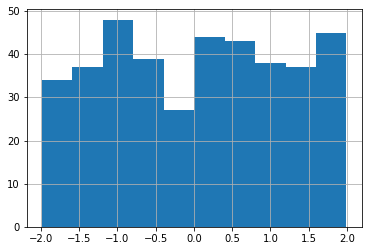

In [7]:
df_cc.x.hist()

In [8]:
df_cc.x[0]

-1.9845445034051448

In [9]:
def r_parallel_ipw(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return (df.omega[j]/pi(df.y[j],b0,b1))*(df.y[j]-y_hat)**2 #/pi(df.y[j],b0,b1)

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))
    
def r_parallel_cc(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return df.omega[j]*(df.y[j]-y_hat)**2 #/pi(df.y[j],b0,b1)

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [10]:
#r_parallel(0.001)

In [11]:
%%time
# r_parallel(0.1)
h_ipw_ipw  = minimize(r_parallel_ipw, 0.1).x

h_ipw_cc = minimize(r_parallel_cc, 0.1).x

CPU times: user 14 s, sys: 1.64 s, total: 15.6 s
Wall time: 28.3 s


In [12]:
print(h_ipw_ipw)
print(h_ipw_cc)

[0.068517]
[0.06852192]


(-1.0, 1.2)

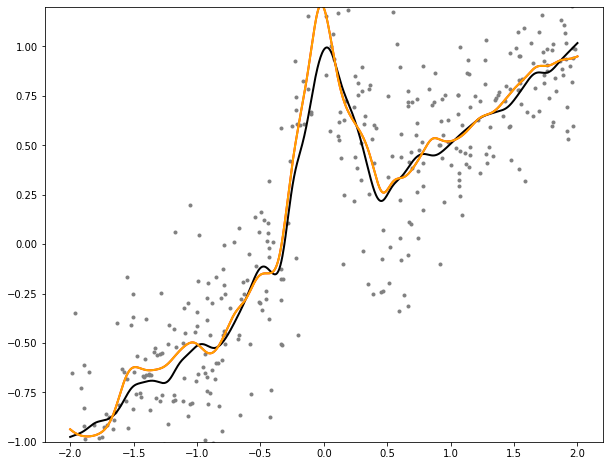

In [13]:
fig, ax = plt.subplots(1, 1,figsize=(10, 8))
#ax.plot(df['x'], df['y'], 'o', color='grey',markersize=2)

#First plot 

#Complete-cases
ax.plot(df_cc['x'], df_cc['y'], 'o', color='grey',markersize=3)
#Truth
ax.plot(np.linspace(-2, 2, n),model.fit(np.linspace(-2, 2, n))[0] ,color= 'black', lw=2)
#CC estimator 
ax.plot(np.linspace(-2, 2, n),model_cc.fit(np.linspace(-2, 2, n))[0] ,color= 'red', lw=2)
#CV bandwidth 
ax.plot(np.linspace(-2, 2, n),[nw_mis(h_ipw_cc,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'orange', lw=2)

ax.set_ylim(-1,1.2)

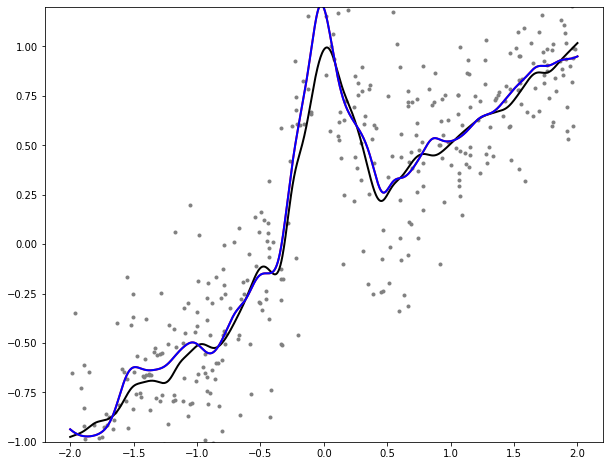

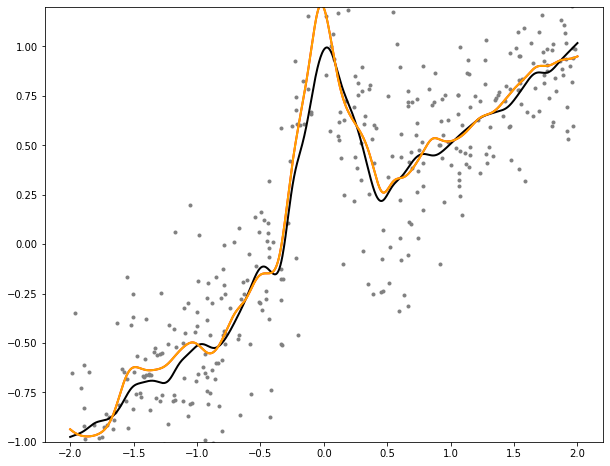

In [14]:
fig, ax = plt.subplots(1, 1,figsize=(10, 8))
#ax.plot(df['x'], df['y'], 'o', color='grey',markersize=2)

#First plot 

#Complete-cases
ax.plot(df_cc['x'], df_cc['y'], 'o', color='grey',markersize=3)
#Truth
ax.plot(np.linspace(-2, 2, n),model.fit(np.linspace(-2, 2, n))[0] ,color= 'black', lw=2)
#CC estimator 
ax.plot(np.linspace(-2, 2, n),model_cc.fit(np.linspace(-2, 2, n))[0] ,color= 'red', lw=2)
#CV bandwidth 
ax.plot(np.linspace(-2, 2, n),[nw_mis(h_ipw_ipw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'blue', lw=2)

ax.set_ylim(-1,1.2)

plt.savefig(f'Fixed Cross-Validated Regression 1.pdf',transparent=True)


#Second plot 

fig, ax = plt.subplots(1, 1,figsize=(10, 8))

ax.plot(df_cc['x'], df_cc['y'], 'o', color='grey',markersize=3)
#Truth
ax.plot(np.linspace(-2, 2, n),model.fit(np.linspace(-2, 2, n))[0] ,color= 'black', lw=2,)
#CC estimator 
ax.plot(np.linspace(-2, 2, n),model_cc.fit(np.linspace(-2, 2, n))[0] ,color= 'red', lw=2)
#CC bandwidth 
ax.plot(np.linspace(-2, 2, n),[nw_mis(h_ipw_ipw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'orange', lw=2)

#Sanity check
#ax.plot(np.linspace(-2, 2, n),[nw_cc(model_cc.bw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'black', lw=2)

ax.set_ylim(-1,1.2)


plt.savefig(f'Fixed Cross-Validated Regression 2.pdf',transparent=True)




In [15]:
h_ipw_cc

array([0.06852192])

In [16]:
model.bw

array([0.0625259])

In [17]:
h_ipw_ipw

array([0.068517])

In [18]:
model_cc.bw

array([0.06854807])

In [19]:
#df.to_csv('simulation.csv')

In [20]:
df['res'] = df['y'] - model.fit(df['x'])[0]



In [31]:
df['res']

0      0.225076
1     -0.286169
2     -0.208577
3     -0.188129
4     -0.264778
         ...   
995    0.254200
996   -0.135320
997    0.172460
998    0.257045
999    0.039059
Name: res, Length: 1000, dtype: float64

In [30]:
np.trapz(df['res']**2)

111.66806257386588

In [21]:
df_cc['res_cc'] = df_cc['y'] - model.fit(df_cc['x'])[0]

In [23]:
df_cc['res_ipw'] = df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw_ipw,t,X,y,pi(y,b0,b1),omega))

In [26]:
df_cc['res_ipw_hcc'] = df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw_cc,t,X,y,pi(y,b0,b1),omega))

In [27]:
df[['res']].describe()

,res
count,1000.000000
mean,-0.000041
std,0.334374
min,-1.854018
25%,-0.198477
50%,-0.008025
75%,0.181238
max,1.395797


<Axes: >

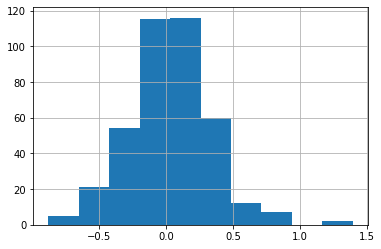

In [28]:
df_cc.res_cc.hist()

<Axes: >

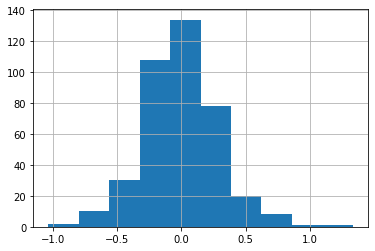

In [29]:
df_cc.res_ipw.hist()